In [1]:
# math 
import numpy as np

# random
import random
from numpy.random import rand, randn

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# linear regression two ways
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# pytorch utils
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(324891)

from patsy import dmatrices

In [2]:
# plot line y = w*x+b
def plotline(w,b, xmin=-100,xmax=100,nsamples=100,label=''):
    x = np.linspace(xmin, xmax, nsamples)
    y = w * x + b
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

In [3]:
# plot function y = f(x)
def plotfunc(f, xmin=-100,xmax=100,nsamples=100,label=""):
    x = np.linspace(xmin, xmax, nsamples)
    y = f(x)
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

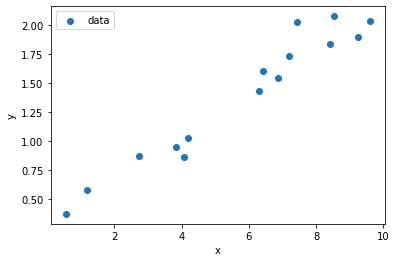

In [4]:
# Generate and plot data
random.seed(1)
n = 15
def sample_data(num_points):
    x = rand(num_points)*10
    y = .2 + .2*x + .1*np.sin(x) + .1*randn(num_points) - .01*((x-5)/6)**4
    return x,y

x,y = sample_data(n)


def plotdata(x=x,y=y, margin=.05):
    plt.scatter(x,y, label="data")
    plt.legend(loc="upper left")
    plt.xlabel("x") 
    plt.ylabel("y")     
    range_y = np.max(y) - np.min(y)
    range_x = np.max(x) - np.min(x)
    plt.ylim([np.min(y)-margin*range_y,np.max(y)+margin*range_y])
    plt.xlim([np.min(x)-margin*range_x,np.max(x)+margin*range_x])
    
plotdata()
plt.show()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = np.ones((n,1))
w = np.linalg.lstsq(X, y)[0]

<ipython-input-5-6dd8b0414b56>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [6]:
# check the solution to our least squares problem is the mean
np.abs(np.mean(y) - w[0])

2.220446049250313e-16

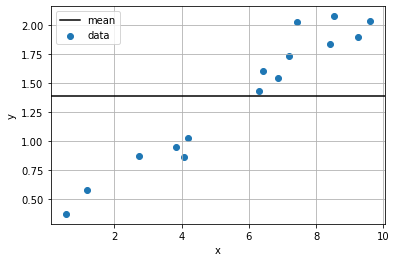

In [7]:
# plot the fit
plotdata()
plotline(0, w[0], label="mean")
plt.show()

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Approximating with a line

In [8]:
X = np.column_stack([x, np.ones(n)])
print(X)

[[8.53021912 1.        ]
 [9.24416659 1.        ]
 [1.20056666 1.        ]
 [7.42936522 1.        ]
 [9.60508256 1.        ]
 [3.8277163  1.        ]
 [2.72402235 1.        ]
 [8.41619135 1.        ]
 [6.31168778 1.        ]
 [4.0778361  1.        ]
 [4.19716118 1.        ]
 [0.5622357  1.        ]
 [6.87276363 1.        ]
 [6.40771197 1.        ]
 [7.19303812 1.        ]]


# How to fit a least squares model
There are many ways to fit a least squares model in python!
1. QR decomposition + `scipy.linalg.solve`
2. `numpy.linalg.lstsq`
3. `statsmodels.OLS`
4. `sklearn.LinearRegression()`

In [9]:
# method 0: scipy
from scipy.linalg import qr, solve
Q,R = qr(X, mode='economic')
w = solve(R, Q.T @ y)
w

array([0.19351084, 0.270056  ])

In [10]:
# method 1: numpy
w = np.linalg.lstsq(X, y)[0]
w

<ipython-input-10-4844ed0cbb71>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


array([0.19351084, 0.270056  ])

In [11]:
# method 2: statsmodels
model = sm.OLS(y, X).fit()
w = model.params
w

array([0.19351084, 0.270056  ])

In [12]:
# method 3: sklearn
model = LinearRegression().fit(x[None,].T,y)
w = np.array([model.coef_[0], model.intercept_])
w

array([0.19351084, 0.270056  ])

In [13]:
# method 4: PyTorch via SGD

def TorchLinRegModel(n : int = 2):
    return nn.Linear(in_features=n, out_features=1, bias=False)

model = TorchLinRegModel()
model.zero_grad()
optimizer = optim.SGD(model.parameters(), lr=5e-6)
loss_function = nn.MSELoss()

n_epochs = 5000
batch_size = 8

for epoch in range(n_epochs):
    # let's do a random order after converting to a torch array
    shuffled_indices = torch.randperm(x.shape[0])
    for batch in range(0, x.shape[0], batch_size):
        sample_idxs = shuffled_indices[batch:batch+batch_size]
        # pytorch helpfully accumulates gradients on backwards passes
        # this means that we need to clear the accumulated gradients 
        # between updats
        optimizer.zero_grad()
        # Read minibatch data. PyTorch models default to float  
        # bc GPUs are optimized for them
        tensor = torch.from_numpy(X[sample_idxs, :]).float()
        output = model(tensor)
        batch_labels = torch.from_numpy(y[sample_idxs]).float()
        batch_labels = batch_labels.view(-1, 1)
        loss = loss_function(output, batch_labels)
        loss.backward()
        optimizer.step()
        
        
w = list(model.parameters())[0][0].detach().numpy()
w

array([0.18918577, 0.22708626], dtype=float32)

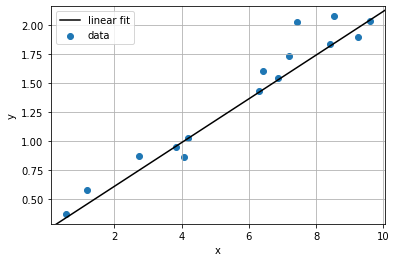

In [14]:
# plot the fit
plotdata()
plotline(w[0], w[1], label="linear fit")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

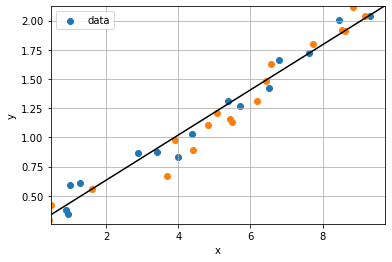

In [13]:
# plot fit on out of sample data
plotdata()
plotline(w[0], w[1])

xtest,ytest = sample_data(20)
plt.scatter(xtest,ytest,label="test")

# Approximating with a polynomial

In [14]:
# first, construct a Vandermonde matrix
n = 15
max_order = 10
X = np.zeros((n, max_order+1))

# method 1: use the default Vandermonde function from numpy
X = np.vander(x, max_order+1, increasing = True)
# method 2: use a for loop
# for k in range(max_order+1):
#     X[:,k] = x**(k)
    
# create a pandas dataframe with data = Vandermonde
col_list = ["order"+str(i) for i in range(max_order+1)]   
df1 = pd.DataFrame(data = X, columns=col_list)
df1

,order0,order1,order2,order3,order4,order5,order6,order7,order8,order9,order10
0,1.0,5.707715,32.578013,185.946024,1061.326960,6057.752080,34575.923964,1.973495e+05,1.126415e+06,6.429256e+06,3.669636e+07
1,1.0,7.608896,57.895296,440.519279,3351.865319,25503.994142,194057.235385,1.476561e+06,1.123500e+07,8.548595e+07,6.504537e+08
2,1.0,9.317787,86.821147,808.980921,7537.911589,70236.651595,654450.131085,6.098027e+06,5.682011e+07,5.294377e+08,4.933187e+09
3,1.0,4.385738,19.234699,84.358351,369.973633,1622.607457,7116.331345,3.121037e+04,1.368805e+05,6.003220e+05,2.632855e+06
4,1.0,0.944209,0.891530,0.841790,0.794826,0.750481,0.708611,6.690764e-01,6.317477e-01,5.965017e-01,5.632220e-01
5,1.0,5.367852,28.813836,154.668407,830.237126,4456.590063,23922.316125,1.284115e+05,6.892937e+05,3.700027e+06,1.986119e+07
6,1.0,1.264771,1.599645,2.023184,2.558864,3.236375,4.093273,5.177051e+00,6.547782e+00,8.281443e+00,1.047413e+01
7,1.0,3.403652,11.584845,39.430775,134.208623,456.799402,1554.786039,5.291950e+03,1.801195e+04,6.130642e+04,2.086657e+05
8,1.0,6.526286,42.592404,277.970193,1814.112871,11839.418731,77267.428134,5.042693e+05,3.291006e+06,2.147804e+07,1.401718e+08
9,1.0,3.990179,15.921531,63.529762,253.495143,1011.491070,4036.030722,1.610449e+04,6.425979e+04,2.564081e+05,1.023114e+06


In [15]:
# helper function: create a Vandermonde matrix in pandas.dataframe
def Vandermonde_df(x, order = max_order):
    X = np.vander(x, order+1, increasing = True)
    col_list = ["order"+str(i) for i in range(order+1)]   
    df = pd.DataFrame(data = X, columns=col_list)
    return df

In [16]:
# solve least squares problem
model = sm.OLS(y, df1).fit()
w = model.params
print(w)

order0     -29.564624
order1     105.746812
order2    -154.673123
order3     124.049483
order4     -60.552745
order5      18.916645
order6      -3.857696
order7       0.510612
order8      -0.042242
order9       0.001983
order10     -0.000040
dtype: float64


In [17]:
# output the prediction given our polynomial fit
df1.dot(w)

0     1.286972
1     1.734197
2     2.037899
3     1.031370
4     0.460575
5     1.270752
6     0.601113
7     0.811484
8     1.482135
9     0.883592
10    0.895129
11    1.601152
12    2.004730
13    0.320947
14    0.536857
dtype: float64

In [18]:
#computes our polynomial fit evaluated at x
def p(x, order = max_order, w = w):
    df = Vandermonde_df(x, order)
    y = df.dot(w)
    return np.array(y)

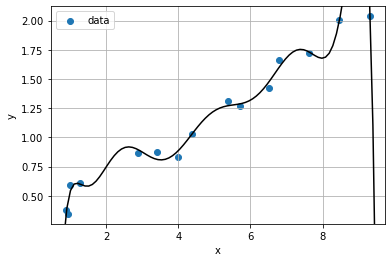

In [19]:
# plot fit
plotdata()
plotfunc(p, xmin=0, xmax=10)

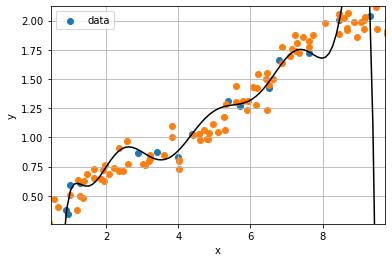

In [20]:
# plot fit on out of sample data
plotdata()
plotfunc(p, xmin=0, xmax=10)

xtest,ytest = sample_data(100)
plt.scatter(xtest,ytest,label="test")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Choosing the best model order

In [21]:
max_model_order = 10
rmse = np.zeros(max_model_order+1)       # array to store root mean square model errors
rmse_train = np.zeros(max_model_order+1) # array to store root mean square model errors on training set
xtest,ytest = sample_data(50)   # generate test set

for model_order in range(max_model_order+1):
    # form Vandermonde matrix
    df = Vandermonde_df(x, model_order)
    
    # solve least squares problem
    model = sm.OLS(y, df).fit()
    w = model.params
    ytrain = df.dot(w)
    
    # compute training error 
    rmse_train[model_order] = np.mean(np.abs(y - np.array(ytrain))) # sqrt(mean((y - X*w).^2))
    
    # compute test error
    ptest = p(xtest, order=model_order, w=w)
    rmse[model_order] = np.mean(np.abs(ytest - np.array(ptest))) # sqrt(mean((ytest - ptest).^2))
rmse

array([0.48236663, 0.09778763, 0.09489738, 0.09407766, 0.09981901,
       0.1134362 , 0.16126981, 0.15316387, 0.13615509, 0.14537774,
       1.48416779])

Text(0, 0.5, 'rmse')

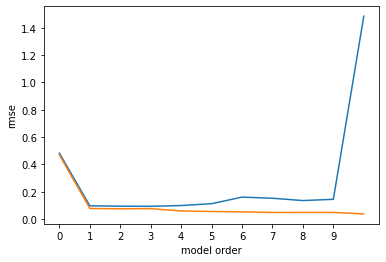

In [22]:
plt.plot(range(max_model_order+1),rmse, label="test error")
plt.plot(range(max_model_order+1),rmse_train, label="train error")
plt.xticks(np.arange(0,10,step=1.0))
plt.xlabel("model order")
plt.ylabel("rmse")

# Polynomial models for classification

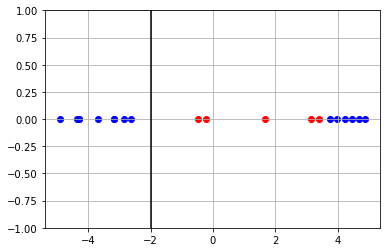

In [23]:
random.seed(0)
n = 20
xs = 10*(rand(n) - .5)
ys = (xs)**2
pos = (xs - 1)**2 >= 7
zn=np.zeros(n)
pt = plt.scatter(xs[pos],zn[pos],color="blue", label="positive")
plt.scatter(xs[~pos],zn[~pos],color="red", label="negative")
plt.plot([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
plt.ylim([-1,1])
plt.grid()
# savefig("poly-class-1d.pdf")
pt

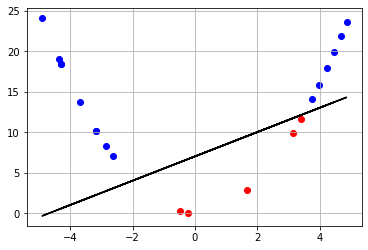

In [24]:
pt = plt.scatter(xs[pos],ys[pos],color="blue", label="positive")
plt.scatter(xs[~pos],ys[~pos],color="red", label="negative")
plt.plot(xs, 1.5*xs + 7, color="black", label="classification boundary")
plt.grid()
# savefig("poly-class-2d.pdf")
pt

In [25]:
# Example 1: multivariate polynomial classification 
n = 1000
scale = 50
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -30 - 9*x1 + 2*x2 + x1**2 - 0*x1*x2 + x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

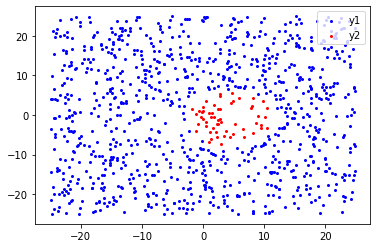

In [26]:
plt.scatter(x1[pos], x2[pos], color="blue", s=4, label='y1')
plt.scatter(x1[neg], x2[neg], color="red", s=4, label='y2')
plt.legend(loc="upper right")

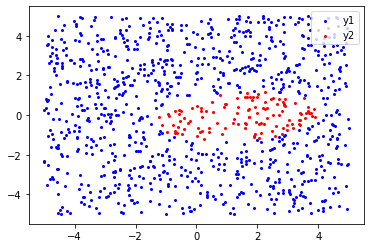

In [27]:
# Example 2: multivariate polynomial classification 
n = 1000
scale = 10
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 + 5*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], s=4, color="blue", label="y1")
plt.scatter(x1[neg], x2[neg], s=4, color="red", label="y2")
plt.legend(loc="upper right")

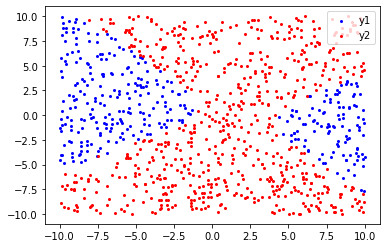

In [28]:
# Example 3: multivariate polynomial classification 
n = 1000
scale = 20
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 - 2*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], color="blue", s=4, label="y1")
plt.scatter(x1[neg], x2[neg], color="red", s=4, label="y2")
plt.legend(loc="upper right")